In [1]:
#Tasks in this project are based on code provided in Kaggle submission:
#Spam Or Ham: SMS Classifier
#By Karnika Kapoor available here https://www.kaggle.com/karnikakapoor/spam-or-ham-sms-classifier
%load_ext watermark
%watermark -a "Group#3 by Su Yagci & Nazmul Rasel" -u -d -v -p numpy,pandas,matplotlib,sklearn,seaborn

Author: Group#3 by Su Yagci & Nazmul Rasel

Last updated: 2021-07-18

Python implementation: CPython
Python version       : 3.9.5
IPython version      : 7.23.1

numpy     : 1.19.5
pandas    : 1.2.4
matplotlib: 3.4.2
sklearn   : 0.24.2
seaborn   : 0.11.1



In [2]:
#Importing the libraries
import numpy as np
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics

In [3]:
#Loading data
data = pd.read_csv("kaggle/input/sms-spam-collection-dataset/spam.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [4]:
#Dropping the unnamed columns
to_drop = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"]
data = data.drop(data[to_drop], axis=1)
#Renaming the columns as Label and SMS
print('Group#3 by Su Yagci & Nazmul Rasel')
data.rename(columns = {"v1":"Label", "v2":"SMS"}, inplace = True)
data.head()

Group#3 by Su Yagci & Nazmul Rasel


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# 1- Data Exploration

## Unbalance Data

Group#3 by Su Yagci & Nazmul Rasel


Text(0, 0.5, 'Number of SMS text messages')

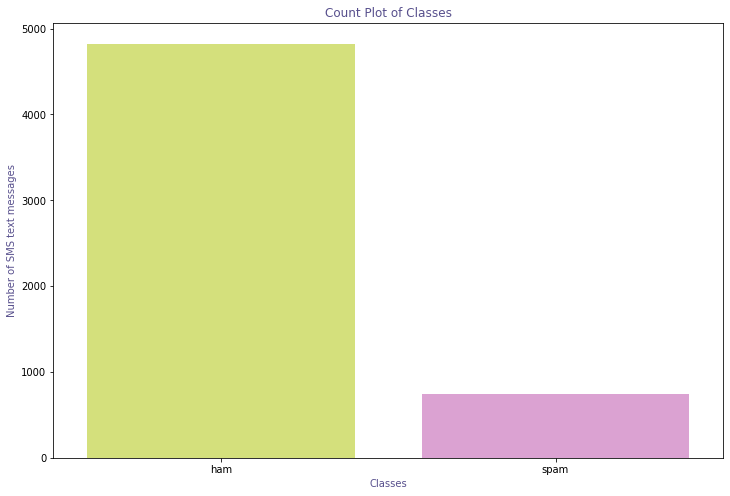

In [5]:
#Colors to be used for graphs and plots
cols= ["#E1F16B", "#E598D8"]
#Checking for Unbalance Data
plt.figure(figsize=(12,8))
fg = sns.countplot(x= data["Label"], palette= cols)
print('Group#3 by Su Yagci & Nazmul Rasel')
fg.set_title("Count Plot of Classes", color="#58508d")
fg.set_xlabel("Classes", color="#58508d")
fg.set_ylabel("Number of SMS text messages", color="#58508d")

## Feature Engineering

In [6]:
#Adding new columns for number of characters, words and sentences in each SMS text message
print('Group#3 by Su Yagci & Nazmul Rasel')
data["Number_of_Characters"] = data["SMS"].apply(len)
data["Number_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row["SMS"]), axis=1).apply(len)
data["Number_of_Sentences"]=data.apply(lambda row: nltk.sent_tokenize(row["SMS"]), axis=1).apply(len)
data.describe().T

Group#3 by Su Yagci & Nazmul Rasel


,count,mean,std,min,25%,50%,75%,max
Number_of_Characters,5572.0,80.058327,59.623937,2.0,36.0,61.0,121.0,910.0
Number_of_Words,5572.0,18.699928,13.738763,1.0,9.0,15.0,27.0,220.0
Number_of_Sentences,5572.0,1.993001,1.503584,1.0,1.0,2.0,2.0,38.0


## Outlier Detection

<Figure size 864x576 with 0 Axes>

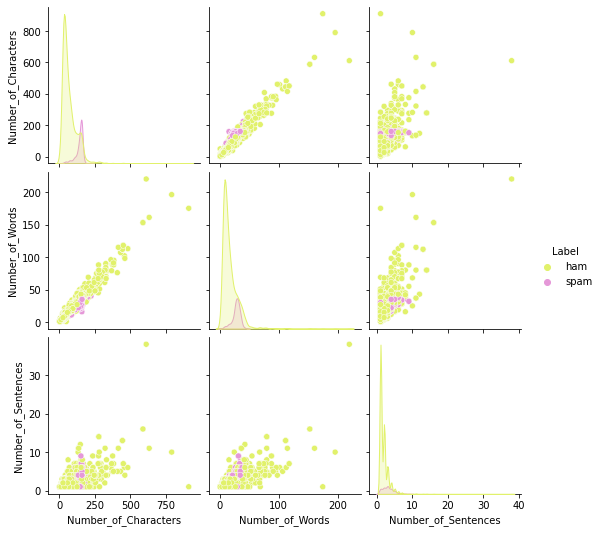

Group#3 by Su Yagci & Nazmul Rasel


In [7]:
#Pair plotting for Outlier Detection 
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Label", palette=cols)
plt.show(fg)
print('Group#3 by Su Yagci & Nazmul Rasel')

In [8]:
#There are outliers in the ham class.
#Dropping the outliers.
print('Group#3 by Su Yagci & Nazmul Rasel')
data = data[(data["Number_of_Characters"]<350)]
data.shape

Group#3 by Su Yagci & Nazmul Rasel


(5548, 5)

<Figure size 864x576 with 0 Axes>

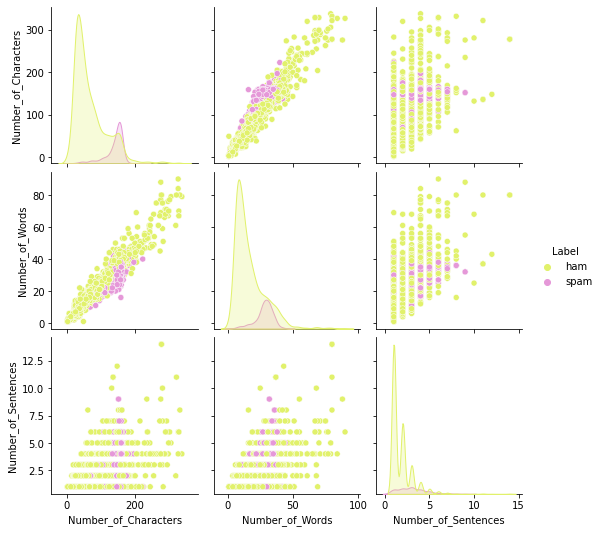

Group#3 by Su Yagci & Nazmul Rasel


In [9]:
#Pair plotting again after dropping the outliers.
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Label",palette=cols)
plt.show(fg)
print('Group#3 by Su Yagci & Nazmul Rasel')

# 2- Data Preprocessing

In [10]:
#Displaying the first 5 SMS text messages before the cleaning step
print("\033[1m\u001b[45;1m The First 5 SMS text messages before cleaning:\033[0m",*data["SMS"][:5], sep = "\n")
print('Group#3 by Su Yagci & Nazmul Rasel')

 The First 5 SMS text messages before cleaning:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Ok lar... Joking wif u oni...
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
U dun say so early hor... U c already then say...
Nah I don't think he goes to usf, he lives around here though
Group#3 by Su Yagci & Nazmul Rasel


## Data cleaning

In [11]:
#Replacing all non-alphabetic characters with space character, and converting to lowercase
def Clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text) 
    sms = sms.lower()
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

data["Clean_Text"] = data["SMS"].apply(Clean)
#Displaying the first 5 SMS text messages after the cleaning step
print("\033[1m\u001b[45;1m The First 5 SMS text messages after cleaning:\033[0m",*data["Clean_Text"][:5], sep = "\n")
print('Group#3 by Su Yagci & Nazmul Rasel')

 The First 5 SMS text messages after cleaning:
go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though
Group#3 by Su Yagci & Nazmul Rasel


## Tokenization

In [12]:
#Tokenization
data["Tokenize_Text"]=data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)
print("\033[1m\u001b[45;1m The First 5 SMS text messages after Tokenization:\033[0m",*data["Tokenize_Text"][:5], sep = "\n")
print('Group#3 by Su Yagci & Nazmul Rasel')

 The First 5 SMS text messages after Tokenization:
['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']
Group#3 by Su Yagci & Nazmul Rasel


In [13]:
# Removing the stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

data["Nostopword_Text"] = data["Tokenize_Text"].apply(remove_stopwords)
print("\033[1m\u001b[45;1m The First 5 SMS text messages after removing the stopwords:\033[0m",*data["Nostopword_Text"][:5], sep = "\n")
print('Group#3 by Su Yagci & Nazmul Rasel')

 The First 5 SMS text messages after removing the stopwords:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']
Group#3 by Su Yagci & Nazmul Rasel


## Lemmatization

In [14]:
#Lemmatization
lemmatizer = WordNetLemmatizer()
def lemmatize_word(text):
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

data["Lemmatized_Text"] = data["Nostopword_Text"].apply(lemmatize_word)
print("\033[1m\u001b[45;1m The First 5 SMS text messages after lemmatization:\033[0m",*data["Lemmatized_Text"][:5], sep = "\n")
print('Group#3 by Su Yagci & Nazmul Rasel')

 The First 5 SMS text messages after lemmatization:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'get', 'amore', 'wat']
['ok', 'lar', 'joke', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'go', 'usf', 'live', 'around', 'though']
Group#3 by Su Yagci & Nazmul Rasel


## Vectorization

In [15]:
#Vectorization
#Creating a corpus of SMS feature to encode further into vectorized form
corpus= []
for i in data["Lemmatized_Text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)
    
corpus[:5]
print("\033[1m\u001b[45;1m The First 5 lines in corpus :\033[0m",*corpus[:5], sep = "\n")
print('Group#3 by Su Yagci & Nazmul Rasel')

 The First 5 lines in corpus :
go jurong point crazy available bugis n great world la e buffet cine get amore wat
ok lar joke wif u oni
free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
u dun say early hor u c already say
nah think go usf live around though
Group#3 by Su Yagci & Nazmul Rasel


In [16]:
#Changing text data into numerical values. 
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
print('Group#3 by Su Yagci & Nazmul Rasel')
#Checking the feature data type
X.dtype

Group#3 by Su Yagci & Nazmul Rasel


dtype('float64')

In [17]:
#Encoding the Label and use it as y
label_encoder = LabelEncoder()
data["Label"] = label_encoder.fit_transform(data["Label"])

# 3- Model Building

## Feature Setting & Split Training / Testing Set

In [18]:
#Setting values for labels and feature as y and X (X was already defined in vectorization step)
y = data["Label"] 
# Splitting the testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4- Model Training

In [19]:
#Training of Multinomial Naive Bayes, Extra Tree Classifier, and Support Vector Machine models
classifiers = [MultinomialNB(), 
               ExtraTreesClassifier(), 
               SVC()]
for cls in classifiers:
    cls.fit(X_train, y_train)

# 5- Model Evaluation

In [20]:
# Model evaluation of 3 algorithms with several metrics such as precision, recall, F1 score, and accuracy
precision =[]
recall =[]
f1_score = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers:
    pred_train = i.predict(X_train)
    pred_test = i.predict(X_test)
    prec = metrics.precision_score(y_test, pred_test)
    recal = metrics.recall_score(y_test, pred_test)
    f1_s = metrics.f1_score(y_test, pred_test)
    train_accuracy = metrics.accuracy_score(y_train, pred_train)
    test_accuracy = metrics.accuracy_score(y_test, pred_test)
  
    precision.append(prec)
    recall.append(recal)
    f1_score.append(f1_s)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)

In [21]:
#Setting evaluation metrics
data = {'Precision':precision,
'Recall':recall,
'F1score':f1_score,
'Accuracy on Testset':testset_accuracy,
'Accuracy on Trainset':trainset_accuracy}
Results = pd.DataFrame(data, index =["Naive Bayesian", "Extra Trees Classifier","Support Vector Machine"])

In [22]:
#Comparison between the model performances
print('Group#3 by Su Yagci & Nazmul Rasel')
cmap2 = ListedColormap(["#E2CCFF","#E598D8"])
Results.style.background_gradient(cmap=cmap2)

Group#3 by Su Yagci & Nazmul Rasel


,Precision,Recall,F1score,Accuracy on Testset,Accuracy on Trainset
Naive Bayesian,1.000000,0.705882,0.827586,0.963964,0.976341
Extra Trees Classifier,0.991150,0.823529,0.899598,0.977477,1.000000
Support Vector Machine,0.990909,0.801471,0.886179,0.974775,0.997521
